In [1]:
# Set up libraries
import pandas as pd
import numpy as np
from numba import njit

import os
from time import time

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go 

from indicators import MACross, Donchian

## Helper Functions

In [ ]:
@njit
def delete(arr, num):
    mask = np.full_like(arr, True, dtype='bool')
    mask[np.array([num])] = False
    return arr[mask]

In [ ]:
def InstrumentWrapper(csv_name):
    import pandas as pd
    df = pd.read_csv(csv_name, index_col='time', parse_dates=True)
    return Instrument(df.index, df.open, df.high, df.low, df.close)

In [57]:
class Instrument:
    from numba import njit
    from numpy import zeros_like as zl, array, int32, datetime64
    
    def __init__(self, timestamp, open, high, low, close, volume = None, spread=0):
        self.tradenumber = 0
        self.timestamp = timestamp.values
        
        self.OHLCV = {}
        self.OHLCV['open']   = open.values
        self.OHLCV['high']   = high.values
        self.OHLCV['low']    = low.values
        self.OHLCV['close']  = close.values
        self.OHLCV['spread'] = spread
        if volume is not None: self.OHLCV['volume'] = volume
        
        self.profitOHLCV = {}
        self.profitOHLCV['open']   = zl(self.OHLCV['open'])
        self.profitOHLCV['high']   = zl(self.OHLCV['high'])
        self.profitOHLCV['low']    = zl(self.OHLCV['low'])
        self.profitOHLCV['close']  = zl(self.OHLCV['close'])
        self.profitOHLCV['volume'] = zl(self.OHLCV['open'], dtype=int32)
        
        self.trades = {}
        self.trades['open'] = {}
        self.trades['current'] = {}
        self.trades['close'] = {}
        self.trades['hist'] = {}
        
        self.trades['open']['tradeNumber'] = array([], dtype=int32)
        self.trades['open']['openTime']    = array([], dtype=datetime64)
        self.trades['open']['openPrice']   = array([])
        self.trades['open']['TP']          = array([])
        self.trades['open']['SL']          = array([])
        self.trades['open']['size']        = array([], dtype=int32)
        
        self.trades['current']['tradeNumber'] = array([], dtype=int32)
        self.trades['current']['openTime']    = array([], dtype=datetime64)
        self.trades['current']['openPrice']   = array([])
        self.trades['current']['TP']          = array([])
        self.trades['current']['SL']          = array([])
        self.trades['current']['size']        = array([], dtype=int32)
        
        self.trades['close']['tradeNumber'] = array([], dtype=int32)
        self.trades['close']['openTime']    = array([], dtype=datetime64)
        self.trades['close']['openPrice']   = array([])
        self.trades['close']['closeTime']   = array([], dtype=datetime64)
        self.trades['close']['closePrice']  = array([])
        self.trades['close']['size']        = array([], dtype=int32)
        self.trades['close']['pnl']         = array([])
        
        self.trades['hist']['tradeNumber'] = array([], dtype=int32)
        self.trades['hist']['openTime']    = array([], dtype=datetime64)
        self.trades['hist']['openPrice']   = array([])
        self.trades['hist']['closeTime']   = array([], dtype=datetime64)
        self.trades['hist']['closePrice']  = array([])
        self.trades['hist']['size']        = array([], dtype=int32)
        self.trades['hist']['pnl']         = array([])
        
        self.data = {}
    
    def add_data(self, name, data):
        if name in ['open', 'high', 'low', 'close', 'volume']:
            raise NameError('These names are reserved. Please use other names.')
        self.data[name] = data        

    def get_data(self, name):
        if name in ['open', 'high', 'low', 'close', 'volume']:
            return self.OHLCV[name]
        else:
            return self.data[name]
    
    @njit
    def open_trade(self, index, price, size, TP=None, SL=None):
        from numpy import concatenate as cc, array
        
        self.price_valid_check(index, price, size)
        self.trades['open']['tradeNumber'] = cc((self.trades['open']['tradeNumber'], 
                                                 array([self.tradenumber])))
        self.tradenumber += 1
        self.trades['open']['openTime']    = cc((self.trades['current']['openTime'], 
                                                array([self.timestamp[index]])))
        self.trades['open']['openPrice']   = cc((self.trades['open']['openPrice'], 
                                                array([price])))
        self.trades['open']['size']        = cc((self.trades['open']['size'], 
                                                array([size])))
        if TP is not None:
            self.trades['open']['TP']      = cc((self.trades['open']['TP'], 
                                                array([TP])))
        else:
            self.trades['open']['TP']      = cc((self.trades['open']['TP'], 
                                                array([np.nan])))
        if SL is not None:
            self.trades['open']['SL']      = cc((self.trades['open']['SL'], 
                                                array([SL])))
        else:
            self.trades['open']['SL']      = cc((self.trades['open']['SL'], 
                                                array([np.nan])))
    
    @njit
    def close_trade(self, index, price):
        from numpy import concatenate as cc, array
        index_to_close = []
        for i in range(len(self.trades['current']['tradeNumber'])):
            self.price_valid_check(index, price, -self.trades['current']['size'][i])
            self.trades['close']['tradeNumber'] = cc((self.trades['close']['tradeNumber'], 
                                                      array(
                                                          [self.trades['current']['tradeNumber'][i]]
                                                      )))
            self.trades['close']['openTime']    = cc((self.trades['close']['openTime'],
                                                      array(
                                                          [self.trades['current']['openTime'][i]]
                                                      )))
            self.trades['close']['openPrice']   = cc((self.trades['close']['openPrice'],
                                                      array(
                                                          [self.trades['current']['openPrice'][i]]
                                                      )))
            self.trades['close']['size']        = cc((self.trades['close']['size'],
                                                      array(
                                                          [self.trades['current']['openPrice'][i]]
                                                      )))
            self.trades['close']['closeTime']   = cc((self.trades['close']['closeTime'],
                                                      array(
                                                          [self.timestamp[index]]
                                                      )))
            self.trades['close']['closePrice']  = cc((self.trades['close']['closePrice'],
                                                      array([price])))
            self.trades['close']['pnl']         = cc((self.trades['close']['pnl'],
                                                      array(
                                                          [round(self.trades['current']['openPrice'][i]*\
                                                                 (price-\
                                                                  self.trades['current']['openPrice'][i]), 
                                                                 2)]
                                                      )))
        for j in index_to_close[::-1]:
            self.trades['current']['tradeNumber'] = self.delete(self.trades['current']['tradeNumber'], j)
            self.trades['current']['openTime']    = self.delete(self.trades['current']['openTime'], j)
            self.trades['current']['openPrice']   = self.delete(self.trades['current']['openPrice'], j)
            self.trades['current']['TP']          = self.delete(self.trades['current']['TP'], j)
            self.trades['current']['SL']          = self.delete(self.trades['current']['SL'], j)
            self.trades['current']['size']        = self.delete(self.trades['current']['size'], j)      
    
    def update_OHLCV(self, index):
        open = self.OHLCV['open'][index]
        high = self.OHLCV['high'][index]
        low  = self.OHLCV['low'][index]
        close = self.OHLCV['close'][index]
        close_1 = self.OHLCV['open'][index-1]
        
        ccsize = self.trades['close']['size']
        csize = self.trades['current']['size']
        osize = self.trades['open']['size']
        
        oopenPrice = self.trades['open']['openPrice']
        ccclosePrice = self.trades['close']['closePrice']
        
        self.profitOHLCV['open'][index]   = (open - close_1) * (ccsize.sum() + csize.sum()) - \
                                            self.OHLCV['spread'] * abs(osize.sum())
        self.profitOHLCV['high'][index]   = (high - close_1) * (csize.sum() + osize.sum())
        self.profitOHLCV['low'][index]    = (low - close_1) * (csize.sum() + osize.sum())
        if self.profitOHLCV['high'][index] < self.profitOHLCV['low'][index]:
            self.profitOHLCV['high'][index], self.profitOHLCV['low'][index] = \
                self.profitOHLCV['low'][index], self.profitOHLCV['high'][index]
        self.profitOHLCV['close'][index]  = (close - close_1) * csize.sum() + \
                  (close - (oopenPrice * (osize/osize.sum())).sum()) * osize.sum() + \
                  ((ccclosePrice * (ccsize/ccsize.sum())).sum() - close_1) * ccsize.sum()
        self.profitOHLCV['volume'][index] = osize.sum() - ccsize.sum()
        
        from numpy import concatenate as cc, array, int32, datetime64
        
        if self.trades['close']['tradeNumber'].size > 0:
            self.trades['hist']['tradeNumber'] = cc((self.trades['hist']['tradeNumber'],
                                                     self.trades['close']['tradeNumber']))
            self.trades['hist']['openTime']    = cc((self.trades['hist']['openTime'],
                                                     self.trades['close']['openTime']))
            self.trades['hist']['closeTime']   = cc((self.trades['hist']['closeTime']
                                                     self.trades['close']['closeTime']))
            self.trades['hist']['openPrice']   = cc((self.trades['hist']['openPrice'],
                                                     self.trades['close']['openPrice']))
            self.trades['hist']['closePrice']  = cc((self.trades['hist']['closePrice'],
                                                     self.trades['close']['closePrice']))
            self.trades['hist']['size']        = cc((self.trades['hist']['size'],
                                                     self.trades['close']['size']))
            self.trades['hist']['pnl']         = cc((self.trades['hist']['pnl'],
                                                     self.trades['close']['pnl']))
            
            self.trades['close']['tradeNumber'] = array([], dtype=int32)
            self.trades['close']['openTime']    = array([], dtype=datetime64)
            self.trades['close']['openPrice']   = array([])
            self.trades['close']['closeTime']   = array([], dtype=datetime64)
            self.trades['close']['closePrice']  = array([])
            self.trades['close']['size']        = array([], dtype=int32)
            self.trades['close']['pnl']         = array([])
            
        if self.trades['open']['tradeNumber'].size > 0:
            self.trades['current']['tradeNumber'] = cc((self.trades['current']['tradeNumber'],
                                                        self.trades['open']['tradeNumber']))
            self.trades['current']['openTime']    = cc((self.trades['current']['openTime'],
                                                        self.trades['open']['openTime']))
            self.trades['current']['openPrice']   = cc((self.trades['current']['openPrice'],
                                                        self.trades['open']['openPrice']))
            self.trades['current']['TP']          = cc((self.trades['current']['TP'],
                                                        self.trades['open']['TP']))
            self.trades['current']['SL']          = cc((self.trades['current']['SL'],
                                                        self.trades['open']['SL']))
            self.trades['current']['size']        = cc((self.trades['current']['size'],
                                                        self.trades['open']['size']))
            
            self.trades['open']['tradeNumber'] = array([], dtype=int32)
            self.trades['open']['openTime']    = array([], dtype=datetime64)
            self.trades['open']['openPrice']   = array([])
            self.trades['open']['TP']          = array([])
            self.trades['open']['SL']          = array([])
            self.trades['open']['size']        = array([], dtype=int32)
        
    @njit
    def delete(arr, num):
        from numpy import full_like, array
        mask = full_like(arr, True, dtype='bool')
        mask[array([num])] = False
        return arr[mask]
    
    def price_valid_check(self, index, price, size):
        # If the price is outside the HL, raise error
        if size > 0:
            if price > (self.OHLCV['high'][index] + self.spread) or \
               price < (self.OHLCV['low'][index]  + self.spread):
                raise ValueError('Price is not within the high-low price of index {}.'.format(index))
        elif size < 0:
            if price > (self.OHLCV['high'][index] - self.spread) or \
               price < (self.OHLCV['low'][index]  - self.spread):
                raise ValueError('Price is not within the high-low price of index {}.'.format(index))
        else:
            raise ValueError('Size cannot be 0.')
            


In [58]:
test = Instrument(ohlc.index, ohlc.open, ohlc.high, ohlc.low, ohlc.close)

In [ ]:
class Strategy:
    def __init__(self):
        self.instruments = {}
        
    def add_instrument(self, name, open, high, low, close, volume = None, spread=0)
        self.instruments[name] = Instrument(open, high, low, close, volume, spread)
        
    # Assumes that your csv headers are [time, open, high, low, close]
    def add_instrument_csv(self, name, csv_name, spread=0):
        from pandas import read_csv
        df = pd.read_csv(csv_name, index_col='time', parse_dates=True)
        self.add_instrument(name, df.index, df.open, df.high, df.low, df.close, df.volume)
    def add_instruments_csv(self, names, csv_names, spreads=None):
        if (len(names) != len(csv_names)) or (spreads is not None and len(spreads) != len(names)):
            raise ValueError('Array lengths of names, csv_names and/or spread are not the same / invalid.')
        if spreads is None: spreads = [0] * len(names)
        for name, csv_name, spread in zip(names, csv_names, spreads):
            self.add_instrument(name, csv_name, spread)
    
    def add_data(self, instrument_name, name, data):
        self.instruments[instrument_name].add_data(name, data)



In [ ]:
class MultiSecurityStrategy:
    
    import os
    
    def __init__(self, csv_path, risk=100, risk_base='SGD',
                 start_range=None, end_range=None):
        self.all_OHLCV = {}
        self.csv_names = [i for i in sorted(os.listdir(csv_path)) if 'csv' in i]
        self.risk = risk
        self.risk_base = risk_base
        self.start_range = start_range
        self.end_range = end_range
        self.init_conditions()
        self.init_prices()
        self.init_trade_log()
        
    def init_conditions(self):
        self.buy_open_conditions = []
        self.buy_close_conditions = []
        self.sell_open_conditions = []
        self.sell_close_conditions = []
    def init_prices(self):
        self.buy_open_prices = []
        self.buy_close_prices = []
        self.sell_open_prices = []
        self.sell_close_prices = []
    def init_trade_log(self):
        self.
    
    def set_granularity(self, gran, parent_path='OHLCV'):
        self.gran = gran
        self.granPath = '{}/{}'.format(parent_path, gran)
        self.csvNames = [i for i in sorted(os.listdir(self.granPath)) if 'csv' in i]
    
    def set_risk(self, risk, risk_base):
        self.risk = risk
        self.risk_base = risk_base
    
    def set_time_range(self, start_range, end_range):
        self.start_range = start_range
        self.end_range = end_range
    
    

In [82]:
#@njit
def MACrossStrat(timestamp, open, high, low, close, 
                 MACross, MAFast, donH, donL, risk, spread=0, lookahead=50):
    def delete(arr, num):
        mask = np.full_like(arr, True, dtype=np.bool)
        mask[np.array([num])] = False
        return arr[mask]
    # Initialise array for info needed per period:
    # Profit OHLCV
    profitOpen   = np.zeros_like(open)
    profitHigh   = np.zeros_like(high)
    profitLow    = np.zeros_like(low)
    profitClose  = np.zeros_like(close)
    profitVolume = np.zeros_like(open, dtype=np.int32)
    # Opening Trades
    otradeNo     = np.array((), dtype=np.int32)
    oopenTime    = np.array((), dtype=np.datetime64)
    oopenPrice   = np.array(())
    osize        = np.array((), dtype=np.int32)
    # Current Trades
    ctradeNo     = np.array((), dtype=np.int32)
    copenTime    = np.array((), dtype=np.datetime64)
    copenPrice   = np.array(())
    csize        = np.array((), dtype=np.int32)
    # Closing Trades
    cctradeNo    = np.array((), dtype=np.int32)
    ccopenTime   = np.array((), dtype=np.datetime64)
    ccopenPrice  = np.array(())
    cccloseTime  = np.array((), dtype=np.datetime64)
    ccclosePrice = np.array(())
    ccsize       = np.array((), dtype=np.int32)
    ccpnl        = np.array(())
    # Historical Trades
    tradeNo      = np.array((), dtype=np.int32)
    openTime     = np.array((), dtype=np.datetime64)
    closeTime    = np.array((), dtype=np.datetime64)
    openPrice    = np.array(())
    closePrice   = np.array(())
    size         = np.array((), dtype=np.int32)
    pnl          = np.array(())
    tradenumber = 1
    
    # Run test for every row of info
    for i in range(lookahead, len(timestamp)):
        index_to_close = []
        # Check for close signals
        for j in range(len(ctradeNo)):
            # If trade is long
            if csize[j] > 0:
                # If Buy close signal happens
                if MACross[i-1] < 0:
                    # Append to closing trade array
                    index_to_close.append(j)
                    cctradeNo = np.concatenate((cctradeNo, np.array([ctradeNo[j]])))
                    ccopenTime = np.concatenate((ccopenTime, np.array([copenTime[j]], dtype=np.datetime64)))
                    ccopenPrice = np.concatenate((ccopenPrice, np.array([copenPrice[j]])))
                    ccsize = np.concatenate((ccsize, np.array([csize[j]])))
                    cccloseTime = np.concatenate((cccloseTime, np.array([timestamp[i]], dtype=np.datetime64)))
                    # Only 
                    ccclosePrice = np.concatenate((ccclosePrice, np.array([open[i]])))
                    ccpnl = np.concatenate((ccpnl, np.array([round(csize[j]*(open[i]-copenPrice[j]), 2)])))
            # Else if trade is short
            else:
                if MACross[i-1] > 0:
                    index_to_close.append(j)
                    cctradeNo = np.concatenate((cctradeNo, np.array([ctradeNo[j]])))
                    ccopenTime = np.concatenate((ccopenTime, np.array([copenTime[j]], dtype=np.datetime64)))
                    ccopenPrice = np.concatenate((ccopenPrice, np.array([copenPrice[j]])))
                    ccsize = np.concatenate((ccsize, np.array([csize[j]])))
                    cccloseTime = np.concatenate((cccloseTime, np.array([timestamp[i]], dtype=np.datetime64)))
                    ccclosePrice = np.concatenate((ccclosePrice, np.array([open[i]])))
                    ccpnl = np.concatenate((ccpnl, np.array([round(csize[j]*(open[i]-copenPrice[j]), 2)])))
        for j in index_to_close[::-1]:
            ctradeNo = delete(ctradeNo, j)
            copenTime = delete(copenTime, j)
            copenPrice = delete(copenPrice, j)
            csize = delete(csize, j)
        if ctradeNo.size < 1:
            if MACross[i-1] > 0:
                otradeNo = np.concatenate((otradeNo, np.array([tradenumber])))
                tradenumber += 1
                oopenTime = np.concatenate((oopenTime, np.array([timestamp[i]], dtype=np.datetime64)))
                oopenPrice = np.concatenate((oopenPrice, np.array([open[i] + spread])))
                #osize = np.concatenate((osize, np.array([int(risk[i]/max(open[i] + spread - donL[i-1],0.00001))])))
                #osize = np.concatenate((osize, np.array([int(risk[i]/max(donH[i-1] - MAFast[i-1],0.00001))])))
                osize = np.concatenate((osize, np.array([int(risk[i]/max(MAFast[i-1] - donL[i-1],0.00001))])))
            elif MACross[i-1] < 0:
                otradeNo = np.concatenate((otradeNo, np.array([tradenumber])))
                tradenumber += 1
                oopenTime = np.concatenate((oopenTime, np.array([timestamp[i]], dtype=np.datetime64)))
                oopenPrice = np.concatenate((oopenPrice, np.array([open[i] - spread])))
                #osize = np.concatenate((osize, np.array([int(risk[i]/min(open[i] + spread - donH[i-1],-0.00001))])))
                #osize = np.concatenate((osize, np.array([int(risk[i]/min(donL[i-1] - MAFast[i-1],-0.00001))])))
                osize = np.concatenate((osize, np.array([int(risk[i]/min(MAFast[i-1] - donH[i-1],-0.00001))])))
        
        profitOpen[i]   = (open[i] - close[i-1]) * (ccsize.sum() + csize.sum()) - \
                          spread * abs(osize.sum())
        profitHigh[i]   = (high[i] - close[i-1]) * (csize.sum() + osize.sum())
        profitLow[i]    = (low[i] - close[i-1]) * (csize.sum() + osize.sum())
        if profitHigh[i] < profitLow[i]:
            profitHigh[i], profitLow[i] = profitLow[i], profitHigh[i]
        profitClose[i]  = (close[i] - close[i-1]) * csize.sum() + \
                          (close[i] - (oopenPrice * (osize/osize.sum())).sum()) * osize.sum() + \
                          ((ccclosePrice * (ccsize/ccsize.sum())).sum() - close[i-1]) * ccsize.sum()
        profitVolume[i] = osize.sum() - ccsize.sum()
        
        if cctradeNo.size > 0:
            tradeNo      = np.concatenate((tradeNo, cctradeNo))
            openTime     = np.concatenate((openTime, ccopenTime))
            closeTime    = np.concatenate((closeTime, cccloseTime))
            openPrice    = np.concatenate((openPrice, ccopenPrice))
            closePrice   = np.concatenate((closePrice, ccclosePrice))
            size         = np.concatenate((size, ccsize))
            pnl          = np.concatenate((pnl, ccpnl))
            
            cctradeNo    = np.array((), dtype=np.int32)
            ccopenTime   = np.array((), dtype=np.datetime64)
            ccopenPrice  = np.array(())
            cccloseTime  = np.array((), dtype=np.datetime64)
            ccclosePrice = np.array(())
            ccsize       = np.array((), dtype=np.int32)
            ccpnl        = np.array(())
        
        if otradeNo.size > 0:
            ctradeNo     = np.concatenate((ctradeNo, otradeNo))
            copenTime    = np.concatenate((copenTime, oopenTime))
            copenPrice   = np.concatenate((copenPrice, oopenPrice))
            csize        = np.concatenate((csize, osize))
            
            otradeNo     = np.array((), dtype=np.int32)
            oopenTime    = np.array((), dtype=np.datetime64)
            oopenPrice   = np.array(())
            osize        = np.array((), dtype=np.int32)
            
    return ((profitOpen, profitHigh, profitLow, profitClose, profitVolume), \
           (ctradeNo, copenTime, copenPrice, csize), \
           (tradeNo, openTime, closeTime, openPrice, closePrice, size, pnl))

In [92]:
rawData = MACrossStrat(
    ohlc.index.values, ohlc.open.values, ohlc.high.values, ohlc.low.values, ohlc.close.values, 
    indic.MACross.values, indic.MAFast.values, indic.DonH.values, indic.DonL.values, riskSeries.values,
    0.0002
)
profitOHLCV = pd.DataFrame.from_records(rawData[0])
profitOHLCV = profitOHLCV.T
profitOHLCV.columns = ['open', 'high', 'low', 'close','volume']
profitOHLCV.index = ohlc.index
histTrades = pd.DataFrame.from_records(rawData[2])
histTrades = histTrades.T
histTrades.columns = ['tradeNo', 'openTime', 'closeTime', 'openPrice', 'closePrice', 'size', 'PnL']
histTrades.set_index('tradeNo', inplace=True)
histTrades['openTime'] = pd.to_datetime(histTrades.openTime)
histTrades['closeTime'] = pd.to_datetime(histTrades.closeTime)

In [ ]:
(histTrades.closeTime - histTrades.openTime).mean()

In [ ]:
histTrades.PnL.sum()

In [ ]:
(profitOHLCV.close - profitOHLCV.open).sum()

In [ ]:
histTrades[histTrades.PnL > 0].shape[0]/histTrades.shape[0]

In [ ]:
histTrades[histTrades.PnL == histTrades.PnL.min()]

In [ ]:
# Don't run candlesticks/make_subplots with big data - it will lag the whole notebook!

# trace0 = go.Candlestick(x = profitOHLCV.index,
#                             open = profitOHLCV.open,
#                             high = profitOHLCV.high,
#                             low = profitOHLCV.low,
#                             close = profitOHLCV.close,
#                             name = 'ProfitOHLCV')

trace0 = go.Scatter(x = profitOHLCV.index,
                    y = profitOHLCV.close - profitOHLCV.open,
                    name = 'PnL per period')

# trace1 = go.Bar(x = profitOHLCV.index,
#                 y = profitOHLCV.volume,
#                 name = 'Volume Change')
data = [trace0]
# fig = tools.make_subplots(rows=2, cols=1, specs=[[{}], [{}]],
#                           shared_xaxes=True, shared_yaxes=True,
#                           vertical_spacing=0.001)
# fig.append_trace(trace0, 1, 1)
# fig.append_trace(trace1, 2, 1)

py.iplot(data)
#py.iplot(fig)

In [ ]:
# Shows the running trades after the backtest has stopped
rawData[1]

In [93]:
equityOHLCV = pd.DataFrame(index=profitOHLCV.index)
equityOHLCV['close'] = profitOHLCV.close.cumsum()
equityOHLCV['open'] = equityOHLCV.close - profitOHLCV.close + profitOHLCV.open
equityOHLCV['high'] = equityOHLCV.close - profitOHLCV.close + profitOHLCV.high
equityOHLCV['low']  = equityOHLCV.close - profitOHLCV.close + profitOHLCV.low
equityOHLCV['volume'] = profitOHLCV.volume.cumsum()

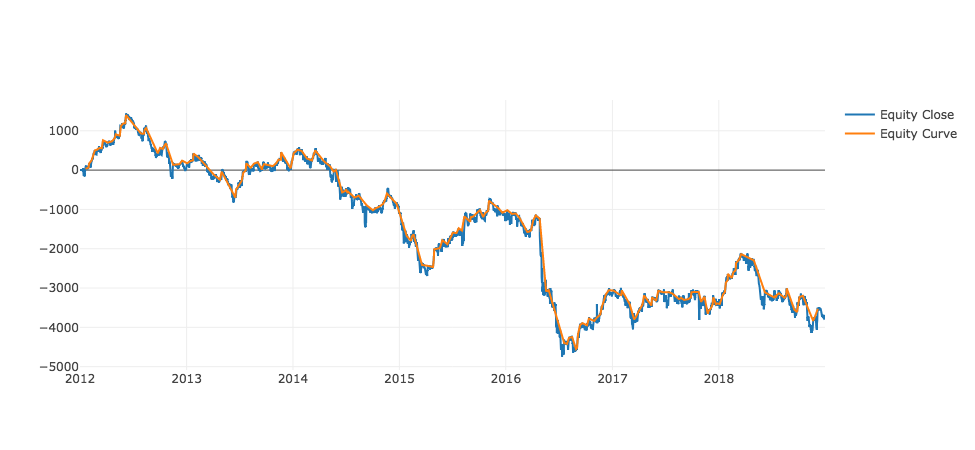

In [94]:
# Don't run candlesticks/make_subplots with big data - it will lag the whole notebook!

# trace0 = go.Candlestick(x = equityOHLCV.index,
#                             open = equityOHLCV.open,
#                             high = equityOHLCV.high,
#                             low = equityOHLCV.low,
#                             close = equityOHLCV.close,
#                             name = 'Equity OHLCV')

trace0 = go.Scatter(x = equityOHLCV.index,
                    y = equityOHLCV.close,
                    name = 'Equity Close')
trace1 = go.Scatter(x = histTrades.closeTime,
                    y = histTrades.PnL.cumsum(),
                    name = 'Equity Curve')
trace2 = go.Bar(x = equityOHLCV.index,
                y = equityOHLCV.volume,
                name = 'Volume')
data = [trace0, trace1]
# fig = tools.make_subplots(rows=2, cols=1, specs=[[{}], [{}]],
#                           shared_xaxes=True, shared_yaxes=True,
#                           vertical_spacing=0.001)
# fig.append_trace(trace1, 1, 1)
# fig.append_trace(trace2, 2, 1)

py.iplot(data)
#py.iplot(fig)

In [8]:
def ohlc_plot(ohlc, indic, start, end):
    trace0 = go.Candlestick(x = ohlc[start:end].index,
                            open = ohlc[start:end].open,
                            high = ohlc[start:end].high,
                            low = ohlc[start:end].low,
                            close = ohlc[start:end].close,
                            name = 'ohlc')
    trace1 = go.Scatter(x = ohlc[start:end].index,
                        y = indic[start:end].MASlow.shift(1),
                        name = 'MA Slow')
    trace2 = go.Scatter(x = ohlc[start:end].index,
                        y = indic[start:end].MAFast.shift(1),
                        name = 'MA Fast')
    trace3 = go.Scatter(x = ohlc[start:end].index,
                        y = indic[start:end].DonH.shift(1),
                        name = 'Donchian High')
    trace4 = go.Scatter(x = ohlc[start:end].index,
                        y = indic[start:end].DonL.shift(1),
                        name = 'Donchian Low')

    data = [trace0, trace1, trace2, trace3, trace4]

    py.iplot(data)

In [ ]:
# For referencing the OHLCV and indicators in question
start = "2015-10-04 00:00:00"
end   = "2015-10-08 23:59:59"

ohlc_plot(ohlc, indic, start, end)

In [9]:
# All OHLCV analysis
allOHLCV = {}
gran = 'H4'
granPath = 'OHLCV/{}'.format(gran)
csvNames = [i for i in sorted(os.listdir(granPath)) if 'csv' in i]

# Risk params
risk = 100
riskBase = 'SGD'

# Range params
start_range = "2012-01-01 00:00:00"
end_range   = "2018-12-31 23:59:59"

start = time()
count = 0
size = len(csvNames)
for csv in csvNames:
    count += 1
    currPair = csv.split('_')[:2]
    cPair = '{}{}'.format(*currPair)
    allOHLCV[cPair] = {}
    
    print('Loading OHLC, indicators and risk values for {} ({}/{})...'.format(cPair, count, size), end='')
    ohlc = pd.read_csv('{}/{}'.format(granPath, csv), index_col='time', parse_dates=True)
    ohlc = ohlc[start_range:end_range]
    if 'JPY' in currPair: ohlc = ohlc/100
    
    indic = pd.DataFrame(index=ohlc.index)
    indic['MACross'] = MACross(ohlc.close, 50, 20)
    indic[['DonH', 'DonL']] = Donchian(ohlc.high, ohlc.low, 20)
    indic['MAFast'] = ohlc.close.rolling(20).mean()
    
    if currPair[1] == riskBase:
        riskSeries = pd.Series(risk, index=ohlc.index)
    elif currPair[0] == riskBase:
        riskSeries = risk * ohlc.open.copy()
    else:
        riskSeries = [i for i in csvNames if riskBase in i and currPair[1] in i][0]
        riskcurrPair = riskSeries.split('_')[:2]
        riskSeries = pd.read_csv('{}/{}'.format(granPath, riskSeries), index_col='time', parse_dates=True)
        riskSeries = riskSeries[start_range:end_range].open
        if 'JPY' in riskcurrPair: riskSeries = riskSeries/100
        riskSeries = pd.Series(riskSeries, index=ohlc.index)
        riskSeries.fillna(method='ffill', inplace=True)
        riskSeries.fillna(method='bfill', inplace=True)
        if riskcurrPair[0] == riskBase:
            riskSeries = risk*riskSeries
        else:
            riskSeries = risk/riskSeries
    print('\rOHLC and indicators loaded. Running MACross... ({}/{})'.format(count, size), end='')
    
    rawData = MACrossStrat(
        ohlc.index.values, ohlc.open.values, ohlc.high.values, ohlc.low.values, ohlc.close.values, 
        indic.MACross.values, indic.MAFast.values, indic.DonH.values, indic.DonL.values, riskSeries.values
    )
    print('\rMACross done. Cleaning data up... ({}/{})'.format(count, size), end='')
    profitOHLCV = pd.DataFrame.from_records(rawData[0])
    profitOHLCV = profitOHLCV.T
    profitOHLCV.columns = ['open', 'high', 'low', 'close','volume']
    profitOHLCV.index = ohlc.index
    histTrades = pd.DataFrame.from_records(rawData[2])
    histTrades = histTrades.T
    histTrades.columns = ['tradeNo', 'openTime', 'closeTime', 'openPrice', 'closePrice', 'size', 'PnL']
    histTrades.set_index('tradeNo', inplace=True)
    histTrades['openTime'] = pd.to_datetime(histTrades.openTime)
    histTrades['closeTime'] = pd.to_datetime(histTrades.closeTime)
    
    equityOHLCV = pd.DataFrame(index=profitOHLCV.index)
    equityOHLCV['close'] = profitOHLCV.close.cumsum()
    equityOHLCV['open'] = equityOHLCV.close - profitOHLCV.close + profitOHLCV.open
    equityOHLCV['high'] = equityOHLCV.close - profitOHLCV.close + profitOHLCV.high
    equityOHLCV['low']  = equityOHLCV.close - profitOHLCV.close + profitOHLCV.low
    equityOHLCV['volume'] = profitOHLCV.volume.cumsum()
    
    allOHLCV[cPair]['profitOHLCV'] = profitOHLCV
    allOHLCV[cPair]['equityOHLCV'] = equityOHLCV
    allOHLCV[cPair]['histTrades']  = histTrades
    
    end = time() - start
    print('\r{} done. {:.2f} seconds elapsed, estimated {:.2f} seconds remaining.'.format(cPair, end, end/count*(size-count)))
    

AUDCAD done. 4.52 seconds elapsed, estimated 158.08 seconds remaining.
AUDCHF done. 8.24 seconds elapsed, estimated 140.15 seconds remaining.
AUDJPY done. 13.66 seconds elapsed, estimated 150.29 seconds remaining.
AUDNZD done. 17.36 seconds elapsed, estimated 138.86 seconds remaining.
AUDSGD done. 21.74 seconds elapsed, estimated 134.76 seconds remaining.
AUDUSD done. 25.70 seconds elapsed, estimated 128.51 seconds remaining.
CADCHF done. 30.42 seconds elapsed, estimated 126.02 seconds remaining.
CADJPY done. 34.23 seconds elapsed, estimated 119.80 seconds remaining.
CADSGD done. 39.16 seconds elapsed, estimated 117.47 seconds remaining.
CHFJPY done. 43.58 seconds elapsed, estimated 113.32 seconds remaining.
EURAUD done. 48.67 seconds elapsed, estimated 110.62 seconds remaining.
EURCAD done. 52.36 seconds elapsed, estimated 104.72 seconds remaining.
EURCHF done. 57.57 seconds elapsed, estimated 101.85 seconds remaining.
EURGBP done. 61.47 seconds elapsed, estimated 96.59 seconds remain

In [ ]:
data = []
filterCPair = []
number = 252
for i in allOHLCV:
    item = allOHLCV[i]['profitOHLCV']
    yaxis = item.close.rolling(number).sum()
    if yaxis[yaxis > 100].count()/yaxis.count() > 0.5:
        trace = go.Scatter(x = item.index,
                           y = item.close.rolling(number).sum(),
                           name = i)
        data.append(trace)
        filterCPair.append(i)
        #print((item.index - item.index.shift(500)).mean())

if data != []: py.iplot(data)

In [ ]:
print(filterCPair)

In [ ]:
def add_currency(i, allOHLCV):
    allOHLCV[i]['histTrades']['pair'] = i
    return allOHLCV[i]['histTrades']
def add_currency_close(i, allOHLCV):
    allOHLCV[i]['profitOHLCV']['pair'] = i
    return allOHLCV[i]['profitOHLCV']

#allHistTrades = [add_currency(i, allOHLCV) for i in allOHLCV if i not in ['EURCHF']]
allHistTrades = [add_currency(i, allOHLCV) for i in filterCPair]
allHistTrades = pd.concat(allHistTrades)
allHistTrades.sort_values(by='closeTime', inplace=True)

allHistTrades_close = [add_currency_close(i, allOHLCV) for i in filterCPair]
allHistTrades_close = pd.concat(allHistTrades_close, axis=1).close.sum(axis=1)

In [ ]:
(allHistTrades.closeTime - allHistTrades.closeTime.shift(75)).mean()

In [ ]:
#number = 500
allHistTrades_close[allHistTrades_close.rolling(number).sum() > 0].count()/(allHistTrades_close.count()-number)

In [ ]:
trace = go.Scatter(x = allHistTrades.closeTime[allHistTrades.closeTime > '2017-01-01'],
                   y = (allHistTrades.PnL[allHistTrades.closeTime > '2017-01-01'].cumsum()/len(filterCPair)),
                   name = 'Total Equity Curve')
trace2 = go.Scatter(x = allHistTrades_close['2017-01-01':].index,
                    y = allHistTrades_close['2017-01-01':].cumsum()/len(filterCPair),
                    name = 'Total Equity Curve by Close')
py.iplot([trace, trace2])

In [ ]:
trace = go.Scatter(x = allHistTrades.closeTime,
                   y = allHistTrades.PnL.rolling(75).sum(),
                   name = 'PnL every {} trades'.format(75))
trace2 = go.Scatter(x = allHistTrades_close.index,
                    y = allHistTrades_close.rolling(number).sum(),
                    name = 'Close PnL every {} trading days'.format(number))
py.iplot([trace, trace2])

In [ ]:
test = ohlc.close
test[test > test.mean()].count()